<font size=5>Deep Neural Network for Image Classification: Application——深度神经网络在图像分类中的应用

In [102]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *
import datetime
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)  # 设置图形的尺寸为5.0x4.0
plt.rcParams['image.interpolation'] = 'nearest'  # 设置图像的插值方式为最近邻插值
plt.rcParams['image.cmap'] = 'gray'  # 设置图像的颜色映射为灰度

# 加载autoreload扩展，用于自动重新加载模块
%load_ext autoreload  
%autoreload 2  # 设置autoreload的模式为自动重新加载所有模块的代码

np.random.seed(1)  # 设置随机种子为1，用于生成随机数的确定性


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


UsageError: unrecognized arguments: # 设置autoreload的模式为自动重新加载所有模块的代码


In [103]:
# 加载数据集
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


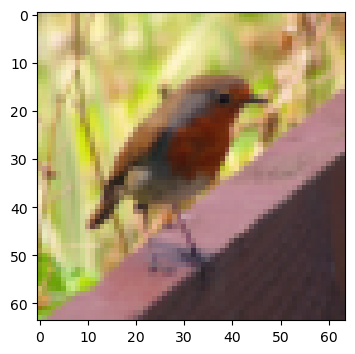

In [104]:
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [105]:
m_train = train_x_orig.shape[0]  # 训练集样本数量
num_px = train_x_orig.shape[1]  # 图像的像素尺寸（假设图像为正方形）
m_test = test_x_orig.shape[0]  # 测试集样本数量

print ("Number of training examples: " + str(m_train))  # 打印训练集样本数量
print ("Number of testing examples: " + str(m_test))  # 打印测试集样本数量
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")  # 打印每张图像的尺寸（宽、高、通道数）
print ("train_x_orig shape: " + str(train_x_orig.shape))  # 打印训练集特征数据的形状
print ("train_y shape: " + str(train_y.shape))  # 打印训练集标签的形状
print ("test_x_orig shape: " + str(test_x_orig.shape))  # 打印测试集特征数据的形状
print ("test_y shape: " + str(test_y.shape))  # 打印测试集标签的形状


Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [106]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T  # 将训练集特征数据展开为一维，并转置
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T  # 将测试集特征数据展开为一维，并转置

train_x = train_x_flatten/255.  # 对训练集特征数据进行归一化处理
test_x = test_x_flatten/255.  # 对测试集特征数据进行归一化处理

print ("train_x's shape: " + str(train_x.shape))  # 打印训练集特征数据的形状
print ("test_x's shape: " + str(test_x.shape))  # 打印测试集特征数据的形状


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [107]:
# 初始化神经网络的参数
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x) * 0.01  # 初始化第一层的权重矩阵W1，采用高斯随机初始化
    b1 = np.zeros((n_h, 1))  # 初始化第一层的偏置向量b1为零向量
    W2 = np.random.randn(n_y, n_h) * 0.01  # 初始化第二层的权重矩阵W2，采用高斯随机初始化
    b2 = np.zeros((n_y, 1))  # 初始化第二层的偏置向量b2为零向量
    
    assert((n_h, n_x) == W1.shape)  # 确保第一层权重矩阵W1的形状正确
    assert((n_h, 1) == b1.shape)  # 确保第一层偏置向量b1的形状正确
    assert((n_y, n_h) == W2.shape)  # 确保第二层权重矩阵W2的形状正确
    assert((n_y, 1) == b2.shape)  # 确保第二层偏置向量b2的形状正确
    
    parameters = {
        "W1": W1,  # 将第一层权重矩阵W1存储到字典parameters中
        "b1": b1,  # 将第一层偏置向量b1存储到字典parameters中
        "W2": W2,  # 将第二层权重矩阵W2存储到字典parameters中
        "b2": b2  # 将第二层偏置向量b2存储到字典parameters中
    }
    
    return parameters  # 返回存储了初始化参数的字典parameters


In [108]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)  # 使用linear_forward函数计算线性部分的输出Z和缓存linear_cache
        A, activation_cache = sigmoid(Z)  # 对Z应用sigmoid激活函数得到A，并得到激活函数的缓存activation_cache
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)  # 使用linear_forward函数计算线性部分的输出Z和缓存linear_cache
        A, activation_cache = relu(Z)  # 对Z应用ReLU激活函数得到A，并得到激活函数的缓存activation_cache
    
    assert(A.shape == (W.shape[0], A_prev.shape[1]))  # 确保A的形状正确
    
    cache = (linear_cache, activation_cache)  # 将线性部分和激活函数的缓存打包成元组
    
    return A, cache  # 返回A和缓存cache作为函数的输出


In [109]:
def compute_cost(AL, Y):
    m = Y.shape[1]  # 样本数量
    
    # 计算成本
    cost = -(np.dot(np.log(AL), Y.T) + np.dot(np.log(1 - AL), (1 - Y).T)) / (1.0 * m)
    cost = np.squeeze(cost)  # 移除维度为1的维度
    assert(cost.shape == ())  # 确保成本的形状为()
    
    return cost


In [110]:
# 激活函数的反向传播的梯度
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache  # 从缓存中获取线性和激活层的缓存
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)  # 使用relu_backward计算dZ
        dA_prev, dW, db = linear_backward(dZ, linear_cache)  # 使用linear_backward计算dA_prev, dW, db
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)  # 使用sigmoid_backward计算dZ
        dA_prev, dW, db = linear_backward(dZ, linear_cache)  # 使用linear_backward计算dA_prev, dW, db
        
    return dA_prev, dW, db


In [111]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2  # 神经网络的层数
    for i in range(1, L + 1):
        parameters["W" + str(i)] -= learning_rate * grads["dW" + str(i)]  # 更新权重参数
        parameters["b" + str(i)] -= learning_rate * grads["db" + str(i)]  # 更新偏置参数
        
    return parameters


In [112]:
n_x = 12288  # 输入层大小
n_h = 7      # 隐藏层大小
n_y = 1      # 输出层大小
layers_dims = (n_x, n_h, n_y) # 元组按顺序存储了每一层的大小


In [113]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    实现一个两层神经网络：LINEAR->RELU->LINEAR->SIGMOID。
    
     参数：
     X -- 输入数据，形状为（n_x，样本数）
     Y -- 真正的“标签”向量（如果是猫则包含 0，如果不是猫则包含 1），形状为（1，示例数）
     layers_dims -- 层的尺寸 (n_x, n_h, n_y)
     num_iterations -- 优化循环的迭代次数
     learning_rate -- 梯度下降更新规则的学习率
     print_cost -- 如果设置为 True，这将每 100 次迭代打印一次成本
    
     退货：
     参数——包含 W1、W2、b1 和 b2 的字典
    """
    
    np.random.seed(1)  # 设置随机种子，以确保实验结果的可重复性
    grads = {}  # 初始化梯度字典，用于存储每个参数的梯度
    costs = []  # 初始化成本列表，用于存储每次迭代的成本值
    m = X.shape[1]  # 训练样本数量
    (n_x, n_h, n_y) = layers_dims  # 获取网络各层的大小

    parameters = initialize_parameters(n_x, n_h, n_y)  # 初始化网络参数

    W1 = parameters["W1"]  # 获取参数W1
    b1 = parameters["b1"]  # 获取参数b1
    W2 = parameters["W2"]  # 获取参数W2
    b2 = parameters["b2"]  # 获取参数b2

    for i in range(0, num_iterations):
        # 前向传播
        A1, cache1 = linear_activation_forward(X, parameters["W1"], parameters["b1"], activation="relu")
        A2, cache2 = linear_activation_forward(A1, parameters["W2"], parameters["b2"], activation="sigmoid")
        
        # 计算成本
        cost = compute_cost(A2, Y)
        
        # 反向传播
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")
        
        grads['dW1'] = dW1  # 存储参数W1的梯度
        grads['db1'] = db1  # 存储参数b1的梯度
        grads['dW2'] = dW2  # 存储参数W2的梯度
        grads['db2'] = db2  # 存储参数b2的梯度
        
        # 更新参数
        parameters = update_parameters(parameters, grads, learning_rate)
        
        W1 = parameters["W1"]  # 更新后的参数W1
        b1 = parameters["b1"]  # 更新后的参数b1
        W2 = parameters["W2"]  # 更新后的参数W2
        b2 = parameters["b2"]  # 更新后的参数b2
        
        # 打印成本
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)
            
    if not(print_cost):
        print("The final cost = %f" %(cost))

    # 绘制成本曲线
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    
    return parameters

Cost after iteration 0: 0.6930497356599888
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605748
Cost after iteration 500: 0.515830477276473
Cost after iteration 600: 0.47549013139433266
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203887
Cost after iteration 900: 0.35807050113237976
Cost after iteration 1000: 0.3394281538366414
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.27491377282130164
Cost after iteration 1300: 0.24681768210614854
Cost after iteration 1400: 0.19850735037466122
Cost after iteration 1500: 0.17448318112556638
Cost after iteration 1600: 0.1708076297809693
Cost after iteration 1700: 0.11306524562164713
Cost after iteration 1800: 0.09629426845937145
Cost after iteration 1900: 0.08342617959726856
Cost after iteration 2000: 0.07439078704319077
Cost after iteration 2100: 0.06630748

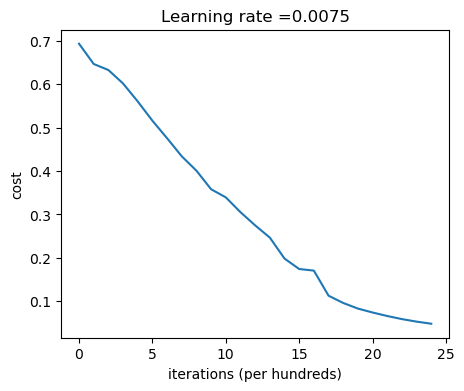

In [114]:
# 调用训练一个两层神经网络模型
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [115]:
# # 不同学习率曲线
# print(datetime.datetime.now())
# two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0005, num_iterations=2500, print_cost=False)
# print(datetime.datetime.now())
# two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0010, num_iterations=2500, print_cost=False)
# print(datetime.datetime.now())
# two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0035, num_iterations=2500, print_cost=False)
# print(datetime.datetime.now())
# two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0075, num_iterations=2500, print_cost=False)
# print(datetime.datetime.now())
# two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0150, num_iterations=2500, print_cost=False)
# print(datetime.datetime.now())
# two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.0750, num_iterations=2500, print_cost=False)
# print(datetime.datetime.now())
# two_layer_model(train_x, train_y, layers_dims=(n_x, n_h, n_y), learning_rate=0.1500, num_iterations=2500, print_cost=False)
# print(datetime.datetime.now())

In [116]:
def predict(X, y, parameters):
    m = X.shape[1]  # 获取样本数量
    n = len(parameters) // 2  # 获取神经网络层数
    p = np.zeros((1, m))  # 创建预测结果的数组
    
    probas, caches = L_model_forward(X, parameters)  # 前向传播得到预测概率
    
    for i in range(probas.shape[1]):  # 对每个样本进行预测
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
            
    accuracy = np.sum(p == y) / (1.0 * m)  # 计算准确率
    print("Accuracy: " + str(accuracy))
    
    return p


In [117]:
predictions_train = predict(train_x, train_y, parameters) # 对训练集进行预测

Accuracy: 1.0


In [118]:
predictions_test = predict(test_x, test_y, parameters)  # 对测试集进行预测

Accuracy: 0.72


In [119]:
# 深度神经网络的参数初始化
def initialize_parameters_deep(layer_dims):
    # 固定随机数种子，以保证可重复性
    np.random.seed(1)
    # 初始化参数字典
    parameters = {}
    # 获取层数
    L = len(layer_dims)
    
    # 遍历每一层，进行参数初始化
    for i in range(1, L):
        # 初始化第 i 层的权重矩阵 W，使用高斯分布，并除以 sqrt(layer_dims[i - 1]) 进行缩放
        parameters['W' + str(i)] = np.random.randn(layer_dims[i], layer_dims[i - 1]) / np.sqrt(layer_dims[i - 1])
        # 初始化第 i 层的偏置向量 b，全部置为零
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))
        
        # 进行维度检查，确保参数的正确性
        assert (layer_dims[i], layer_dims[i - 1]) == parameters["W" + str(i)].shape
        assert (layer_dims[i], 1) == parameters["b" + str(i)].shape
        
    # 返回初始化后的参数字典
    return parameters


In [120]:
# 深度神经网络的前向传播过程
def L_model_forward(X, parameters):
    # 初始化缓存列表，用于存储每一层的缓存信息
    caches = []
    # 将输入数据 X 赋值给 A
    A = X
    # 获取层数
    L = len(parameters) // 2
    
    # 遍历每一层（除最后一层）
    for i in range(1, L):
        # 将当前层的输入 A_prev 和参数 W、b 进行线性激活前向传播计算，并返回计算结果和缓存
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(i)], parameters["b" + str(i)], "relu")
        # 将缓存添加到缓存列表中
        caches.append(cache)
        
    # 对最后一层进行线性激活前向传播计算，并返回计算结果和缓存
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
    # 将缓存添加到缓存列表中
    caches.append(cache)
    
    # 进行维度检查，确保输出 AL 的形状为 (1, m)，其中 m 为样本数
    assert AL.shape == (1, X.shape[1])
    
    # 返回输出 AL 和缓存列表 caches
    return AL, caches


In [121]:
def compute_cost(AL, Y):
    # 获取样本数 m
    m = Y.shape[1]
    
    # 计算交叉熵损失
    cost = -(np.dot(np.log(AL), Y.T) + np.dot(np.log(1 - AL), (1 - Y).T)) / (m * 1.0)
    
    # 压缩维度，将 cost 的维度从 (1, 1) 压缩为一个标量值
    cost = np.squeeze(cost)
    
    # 进行维度检查，确保 cost 的形状为 ()
    assert cost.shape == ()
    
    # 返回损失 cost
    return cost


In [122]:
# 反向传播，计算各层的梯度
def L_model_backward(AL, Y, caches):
    # 初始化梯度字典
    grads = {}
    
    # 获取网络层数
    L = len(caches)
    
    # 获取样本数
    m = AL.shape[1]
    
    # 将实际标签 Y 调整为与 AL 相同的形状
    Y = Y.reshape(AL.shape)
    
    # 计算输出层的梯度 dAL
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # 反向传播输出层的梯度，保存到梯度字典中
    current_cache = caches[L - 1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    # 反向传播隐藏层的梯度，从倒数第二层开始
    for i in reversed(range(L - 1)):
        current_cache = caches[i]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(i + 2)], current_cache, activation="relu")
        grads["dA" + str(i + 1)] = dA_prev_temp
        grads["dW" + str(i + 1)] = dW_temp
        grads["db" + str(i + 1)] = db_temp
    
    # 返回梯度字典
    return grads


In [123]:
# 更新模型的参数
def update_parameters(parameters, grads, learning_rate):
    # 获取网络层数
    L = len(parameters) // 2
    
    # 更新参数
    for i in range(1, L + 1):
        parameters["W" + str(i)] -= learning_rate * grads["dW" + str(i)]
        parameters["b" + str(i)] -= learning_rate * grads["db" + str(i)]
    
    # 返回更新后的参数
    return parameters


In [124]:
layers_dims = [12288, 20, 7, 5, 1] 
"""
网络有五层，分别包含 
                    12288 个输入单元（输入特征的数量），
                    20 个隐藏单元（第一隐藏层），
                    7 个隐藏单元（第二隐藏层），
                    5 个隐藏单元（第三隐藏层），
                    以及 1 个输出单元（预测结果）
"""

'\n网络有五层，分别包含 \n                    12288 个输入单元（输入特征的数量），\n                    20 个隐藏单元（第一隐藏层），\n                    7 个隐藏单元（第二隐藏层），\n                    5 个隐藏单元（第三隐藏层），\n                    以及 1 个输出单元（预测结果）\n'

In [125]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    实现一个L层神经网络：[LINEAR->RELU]*(L-1)->LINEAR->SIGMOID。
    
     参数：
     X -- 数据，形状的 numpy 数组（示例数，num_px * num_px * 3）
     Y -- 真正的“标签”向量（如果是猫则包含 0，如果不是猫则包含 1），形状为（1，示例数）
     layers_dims -- 包含输入大小和每个层大小的列表，长度为（层数 + 1）。
     learning_rate -- 梯度下降更新规则的学习率
     num_iterations -- 优化循环的迭代次数
     print_cost——如果为真，它每 100 步打印一次成本
    
     退货：
     parameters -- 模型学习的参数。 然后可以使用它们进行预测。
    """

    np.random.seed(1)  # 设置随机种子，确保结果可复现
    costs = []  # 用于存储每次迭代的成本值

    parameters = initialize_parameters_deep(layers_dims)  # 初始化模型参数

    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)  # 前向传播，计算预测值AL和缓存caches
        cost = compute_cost(AL, Y)  # 计算成本
        grads = L_model_backward(AL, Y, caches)  # 反向传播，计算梯度
        parameters = update_parameters(parameters, grads, learning_rate)  # 更新参数
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" %(i, cost))  # 打印每100次迭代后的成本
        if print_cost and i % 100 == 0:
            costs.append(cost)  # 将每100次迭代的成本添加到costs列表中

    plt.plot(np.squeeze(costs))  # 绘制成本曲线
    plt.ylabel('cost')  # 设置y轴标签为"cost"
    plt.xlabel('iterations (per tens)')  # 设置x轴标签为"iterations (per tens)"
    plt.title("Learning rate =" + str(learning_rate))  # 设置图表标题为"Learning rate = 学习率值"
    plt.show()  # 显示图表

    return parameters  # 返回训练后的参数


Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


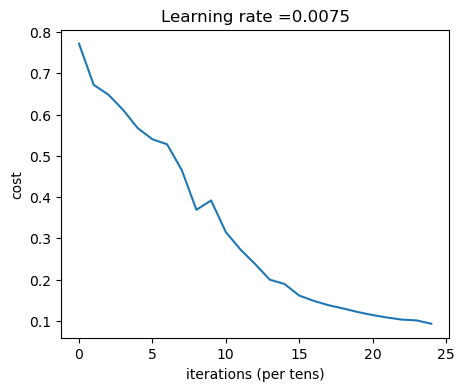

In [126]:
# 调用了函数L_layer_model来训练模型
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [127]:
pred_train = predict(train_x, train_y, parameters) # 对训练集进行预测

Accuracy: 0.9856459330143541


In [128]:
pred_test = predict(test_x, test_y, parameters) # 对测试集进行预测

Accuracy: 0.8


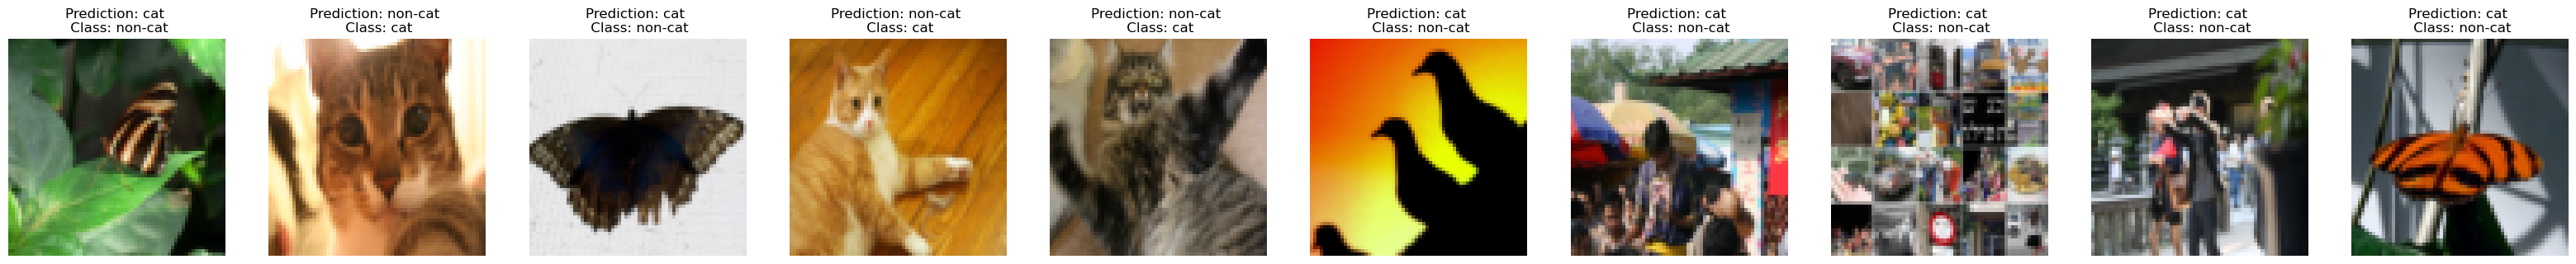

In [129]:
print_mislabeled_images(classes, test_x, test_y, pred_test) # 打印出分类错误的图像

C:\Users\12516\AppData\Local\Temp\ipykernel_18204\1067584433.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = np.array(imageio.imread(fname))  # 读取图像并转换为NumPy数组


Accuracy: 1.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


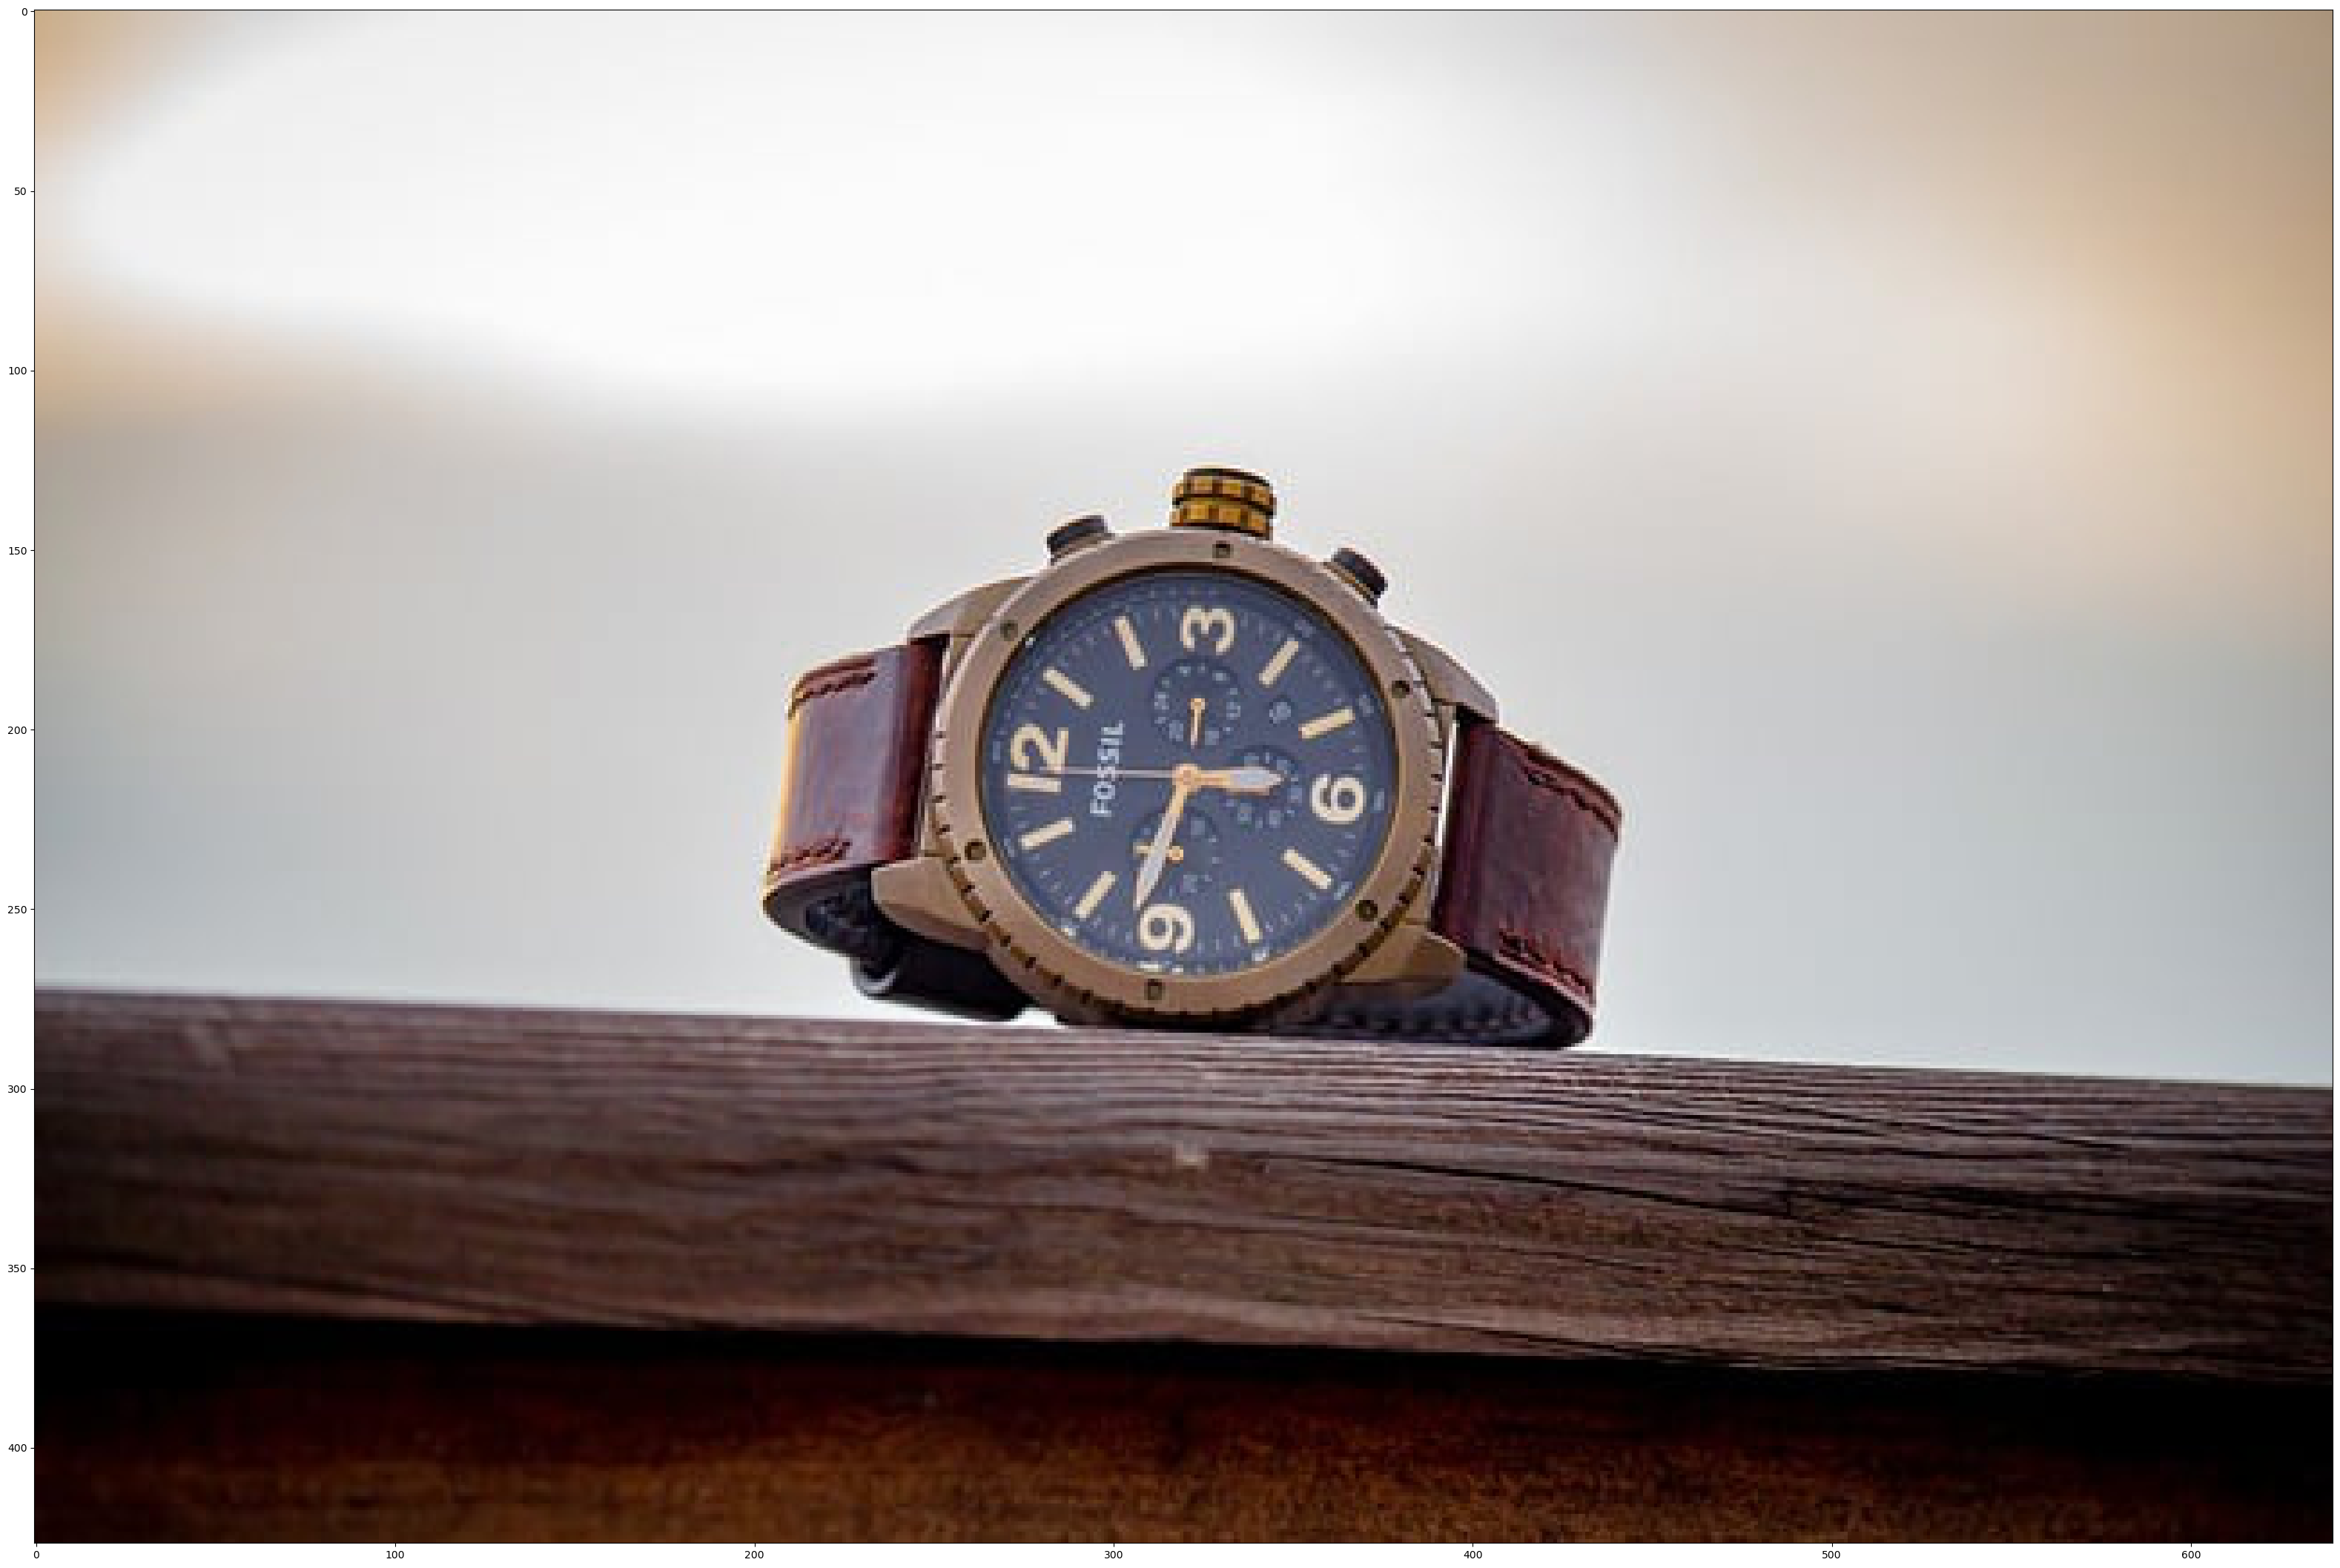

In [140]:
import imageio
from skimage import transform

my_image = "my_image4.jpg"  # 设置要预测的图像文件名
my_label_y = [0]  # 设置图像的标签

fname = my_image  # 构建图像文件路径
image = np.array(imageio.imread(fname))  # 读取图像并转换为NumPy数组
my_image = transform.resize(image, output_shape=(num_px, num_px)).reshape((num_px * num_px * 3, 1))  # 调整图像大小并展平为列向量
my_predicted_image = predict(my_image, my_label_y, parameters)  # 预测图像的标签

plt.imshow(image)  # 显示图像
print("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") + "\" picture.")
